In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, multivariate_logrank_test
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from random import choices
import joblib

In [2]:
df = pd.read_csv('tyg.csv')
df.head()

# df = pd.read_excel('mau.xlsx')
# df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_ercp,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,14.130556,0,0,0,0,0,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,15.834722,0,0,0,0,0,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,21.834722,0,0,0,0,0,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,9.019225,17.736806,0,0,0,0,0,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,10.655556,0,0,0,0,0,0


In [3]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y'],
      dtype='object')

In [4]:
df['creatinine_group'] = pd.qcut(df['creatinine'], q=[0,0.25, 0.5, 0.7, 1], labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['creatinine_group'].value_counts()

creatinine_group
Q4    197
Q1    164
Q2    164
Q3    131
Name: count, dtype: int64

In [5]:
races = {
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'ASIAN - CHINESE': 'Others',
    'ASIAN - SOUTH EAST ASIAN': 'Others',
    'ASIAN - ASIAN INDIAN': 'Others',
    'ASIAN - KOREAN': 'Others',
    'ASIAN': 'Others',
    'HISPANIC OR LATINO': 'Others',
    'HISPANIC/LATINO - PUERTO RICAN': 'Others',
    'HISPANIC/LATINO - GUATEMALAN': 'Others',
    'HISPANIC/LATINO - DOMINICAN': 'Others',
    'HISPANIC/LATINO - MEXICAN': 'Others',
    'HISPANIC/LATINO - SALVADORAN': 'Others',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Others',
    'HISPANIC/LATINO - CUBAN': 'Others',
    'HISPANIC/LATINO - COLUMBIAN': 'Others',
    'HISPANIC/LATINO - HONDURAN': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'SOUTH AMERICAN': 'Others',
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'PORTUGUESE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/AFRICAN': 'Black',
}
df['race'] = df['race'].map(races)

In [6]:
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y,creatinine_group
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,White,5.166100,0,1,...,0,5.166100,14.130556,0,0,0,0,0,0,Q2
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,White,0.776481,0,0,...,0,0.776481,15.834722,0,0,0,0,0,0,Q1
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,White,1.050521,0,1,...,0,1.050521,21.834722,0,0,0,0,0,0,Q1
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,White,9.019225,1,0,...,0,9.019225,17.736806,0,0,0,0,0,0,Q4
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,White,0.572477,1,1,...,0,0.572477,10.655556,0,0,0,0,0,0,Q3


In [7]:
df['duration_7d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 7), 7, df['los'])
df['duration_28d'] = np.where((df['mortality_28d'] == 0) & (df['los'] > 28), 28, df['los'])
df['duration_90d'] = np.where((df['mortality_90d'] == 0) & (df['los'] > 90), 90, df['los'])
df['duration_1y']  = np.where((df['mortality_1y']  == 0) & (df['los'] > 365), 365, df['los'])

# Phân tích Kaplan Meier
## Kiểm định Log Rank
### Hypothosic (Giả thuyết)
H0: Các Qi tương đương nhau

H1: Tồn tại Qi khác nhau

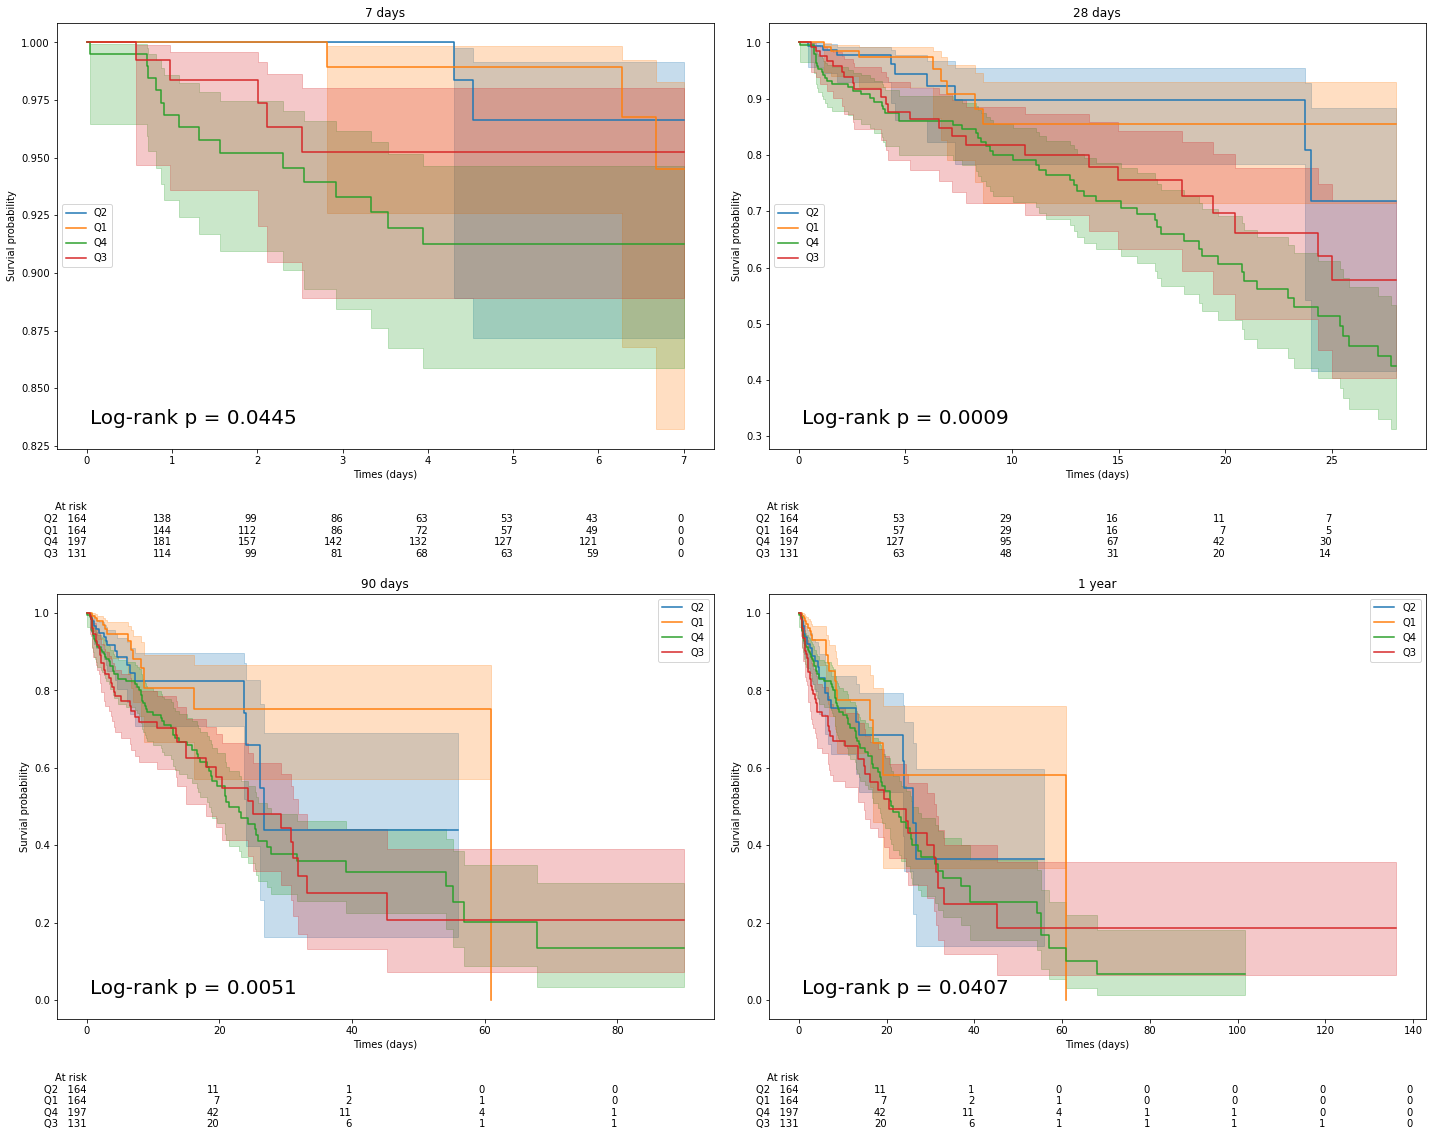

In [8]:
durations = ['duration_7d','duration_28d', 'duration_90d', 'duration_1y']
events = ['mortality_7d','mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 days','28 days', '90 days', '1 year']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 16) )
axes = axes.flatten()
kmf = KaplanMeierFitter()
groups = df['creatinine_group'].unique()
for i in range(len(durations)):
    ax = axes[i]

    models = []
    for group in groups:
        kmf = KaplanMeierFitter()
        kmf.fit(durations = df[df['creatinine_group'] == group][durations[i]], event_observed = df[df['creatinine_group'] == group][events[i]], label=group)
        kmf.plot(ax=ax)
        models.append(kmf)
    results = multivariate_logrank_test(event_durations = df[durations[i]], groups = df['creatinine_group'], event_observed= df[events[i]])
    pval = results.p_value
    ax.text(0.05, 0.05, f"Log-rank p = {pval:.4f}", transform = ax.transAxes, fontsize = 20, verticalalignment = 'bottom')
    add_at_risk_counts(*models, ax = ax, rows_to_show=['At risk'], labels= groups)
    ax.set_title(titles[i])
    ax.set_ylabel('Survial probability')
    ax.set_xlabel('Times (days)')
plt.tight_layout()
plt.show()

In [193]:
import joblib

all_models = {}      # lưu mô hình Kaplan–Meier theo từng thời điểm
all_pvals = {}       # lưu p-value log-rank theo từng thời điểm

for i in range(len(durations)):
    km_models = {}  # mô hình của từng group
    for group in groups:
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=df[df['creatinine_group'] == group][durations[i]],
            event_observed=df[df['creatinine_group'] == group][events[i]],
            label=group
        )
        km_models[group] = kmf

    # log-rank test
    result = multivariate_logrank_test(
        event_durations=df[durations[i]],
        groups=df['creatinine_group'],
        event_observed=df[events[i]]
    )
    all_pvals[titles[i]] = result.p_value

    # lưu mô hình
    all_models[titles[i]] = km_models

# Lưu tất cả mô hình + p-value
joblib.dump((all_models, all_pvals, groups.tolist()), "km_all_models.joblib")

['km_all_models.joblib']

In [168]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y', 'creatinine_group', 'duration_7d', 'duration_28d',
       'duration_90d', 'duration_1y'],
      dtype='object')

# Phân tích ROC AUC
## Tiền xử lý dữ liệu

In [9]:
# cols = ["wbc","rbc","rdw","hemoglobin","platelets",
#           "aniongap","bicarbonate","calcium","chloride","potassium",
#           "creatinine","alt","alp","ast","pt","ptt","inr"]


cols = ['tyg','sofa', 'glucose', 'triglycerides', 'creatinine']
imp = IterativeImputer(max_iter=100)
df[cols] = imp.fit_transform(df[cols])

In [170]:
# cols = ['NPAR', 'neutrophis_max', 'albumin_min','sofa']
# imp = IterativeImputer(max_iter=100)
# df[cols] = imp.fit_transform(df[cols])

## Sử dụng Logistic Regression để phân tích đường cong ROC

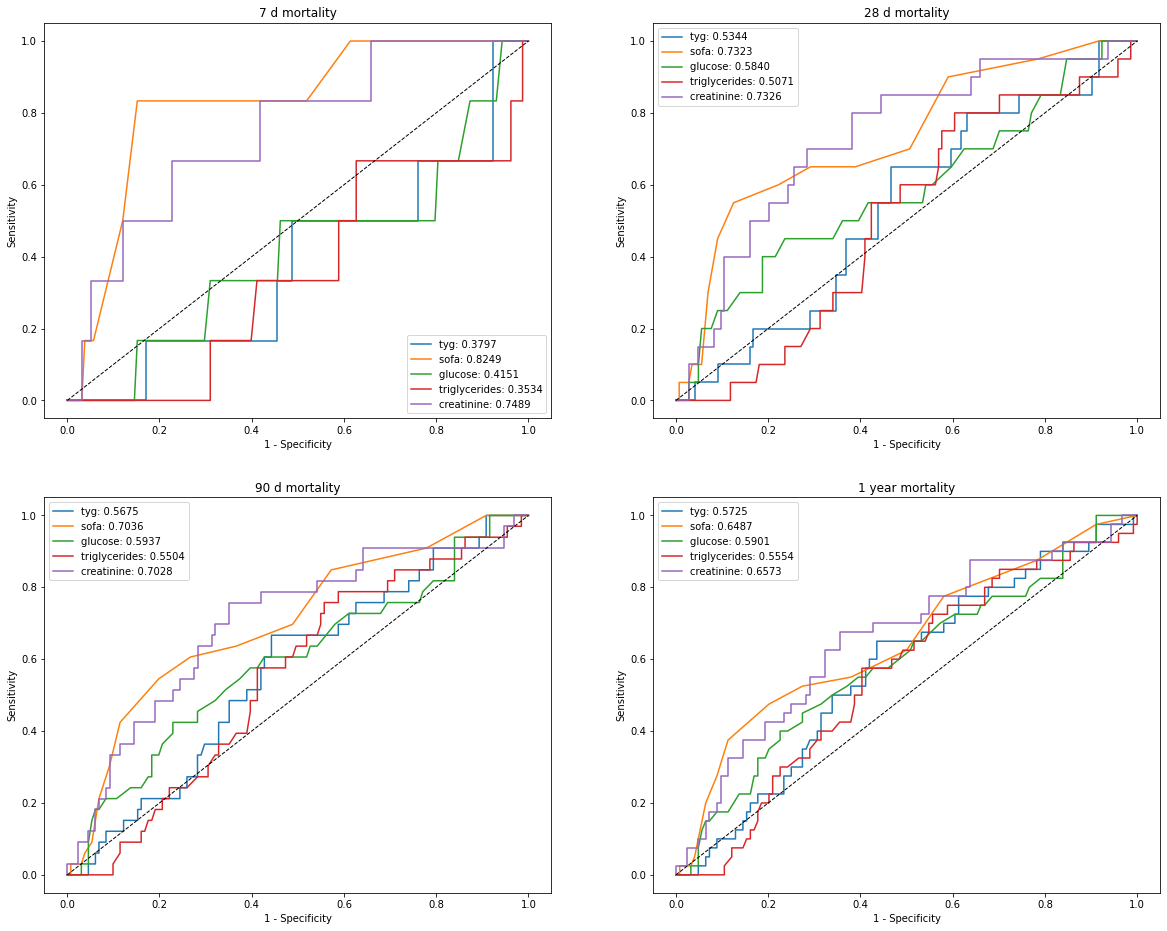

In [10]:
durations = ['duration_7d','duration_28d', 'duration_90d', 'duration_1y']
events = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 d mortality', '28 d mortality', '90 d mortality', '1 year mortality']
lr = LogisticRegression()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 16))
axes = axes.flatten()
for i in range(len(durations)):
    ax = axes[i]
    y = df[events[i]]
    for col in cols:
        X = df[[col]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        ax.plot(fpr, tpr, label=f"{col}: {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    # Tùy chỉnh đồ thị
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    ax.set_title(titles[i])
    ax.legend()
plt.show()

In [11]:
arr = [3, 7, 5, 4, 6, 9]
rs = []
for i in range(1000):
    brr = choices(population=arr, k=len(arr))
    rs.append(np.mean(brr))
np.quantile(rs, q=[0.25, 0.75])


array([5.16666667, 6.16666667])

In [12]:
arr = np.array([3, 7, 5, 4, 6, 9])
brr = np.array([6, 4, 1, 5, 4, 8])
idx = list(range(len(arr)))
idx_sel = choices(idx, k = len(arr))
arr[idx_sel], brr[idx_sel]

(array([5, 9, 9, 9, 4, 4]), array([1, 8, 8, 8, 5, 5]))

In [13]:
def boostrap(y_true, y_prob, n_sample=1000):
    aucs = []
    for _ in range(n_sample):
        idx = np.random.choice(range(len(y_true)), len(y_true), replace=True)
        y_true_bs, y_prob_bs = y_true[idx], y_prob[idx]
        if len(np.unique(y_true_bs)) < 2:
            continue  # bỏ qua mẫu chỉ có 1 lớp
        aucs.append(roc_auc_score(y_true_bs, y_prob_bs))
    if len(aucs) == 0:
        return np.nan, np.nan
    return np.percentile(aucs, 0.25), np.percentile(aucs, 0.75)


In [14]:
events = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 days ', '28 days ', '90 days ', '1 year ']

lr = LogisticRegression()
results = []
for i in range(len(durations)):
    results.append({'Variables': titles[i], 'AUC (%)': '', '95%CI (%)': '', 'Threshold': '', 'Sensitivity': '', 'Specificity': ''})
    y = df[events[i]].values
    for col in cols:
        X = df[[col]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026, stratify=y)
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:, 1]
        y_pred = lr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        ci_low, ci_upper = boostrap(y_test, y_prob, n_sample=1000)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        threshold = sensitivity + specificity - 1
        results.append({'Variables': col,
                    'AUC (%)': f'{roc_auc *100: .2f}',
                    '95%CI (%)' : f'{ci_low * 100:.2f}-{ci_upper * 100:.2f}',
                    'Threshold': f'{threshold:.2f}',
                    'Sensitivity': f'{sensitivity:.2f}',
                    'Specificity': f'{specificity:.2f}'
        })
pd.DataFrame(results)
   

,Variables,AUC (%),95%CI (%),Threshold,Sensitivity,Specificity
0,7 days,,,,,
1,tyg,28.38,5.99-7.17,0.00,0.00,1.00
2,sofa,88.03,73.29-75.85,0.00,0.00,1.00
3,glucose,37.97,4.76-6.23,0.00,0.00,1.00
4,triglycerides,69.04,30.50-37.29,0.00,0.00,1.00
5,creatinine,81.43,63.78-65.72,0.00,0.00,1.00
6,28 days,,,,,
7,tyg,51.09,32.75-35.00,0.00,0.00,1.00
8,sofa,66.26,49.22-52.21,0.04,0.04,1.00
9,glucose,52.90,32.96-34.86,0.00,0.00,1.00


# roc

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy import stats

# ============================
# Hàm tính 95% CI cho AUC
# ============================
def auc_ci(y_true, y_pred, alpha=0.95):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    AUC = auc(fpr, tpr)
    n1 = sum(y_true == 1)
    n0 = sum(y_true == 0)

    Q1 = AUC / (2 - AUC)
    Q2 = (2 * AUC**2) / (1 + AUC)

    SE = np.sqrt((AUC * (1 - AUC) + (n1 - 1)*(Q1 - AUC**2) + (n0 - 1)*(Q2 - AUC**2)) / (n1 * n0))

    z = stats.norm.ppf((1 + alpha) / 2)
    lower = AUC - z * SE
    upper = AUC + z * SE

    return AUC, lower, upper

In [25]:
#  Prepare Data 

covars = ["wbc","rbc","rdw","hemoglobin","platelets",
          "aniongap","bicarbonate","calcium","chloride","potassium",
          "creatinine","alt","alp","ast","pt","ptt","inr"]

In [26]:
# chọn các biến cần thiết
df2 = df[["sepsis","tyg"] + covars].dropna()

X1 = df2[["tyg"]]               # Model 1: chỉ TyG
X2 = df2[["tyg"] + covars]      # Model 2: TyG + 18 biến sinh hóa
y = df2["sepsis"]

In [27]:
# Train-test split: giữ dataset nguyên không chia nhỏ
model1 = LogisticRegression(max_iter=500).fit(X1, y)
model2 = LogisticRegression(max_iter=500).fit(X2, y)

pred1 = model1.predict_proba(X1)[:,1]
pred2 = model2.predict_proba(X2)[:,1]

C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
#  Compute AUC + CI

auc1, ci1_l, ci1_u = auc_ci(y, pred1)
auc2, ci2_l, ci2_u = auc_ci(y, pred2)

# print("Model 1 (TyG only):")
# print(f"AUC = {auc1:.3f}  (95% CI: {ci1_l:.3f} – {ci1_u:.3f})\n")

# print("Model 2 (TyG + biomarkers):")
# print(f"AUC = {auc2:.3f}  (95% CI: {ci2_l:.3f} – {ci2_u:.3f})\n")

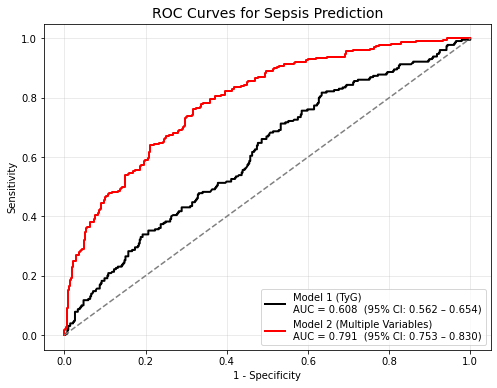

In [33]:
#  Vẽ ROC

fpr1, tpr1, _ = roc_curve(y, pred1)
fpr2, tpr2, _ = roc_curve(y, pred2)

plt.figure(figsize=(8,6))

plt.plot(fpr1, tpr1, color="black", lw=2, label=f"Model 1 (TyG)\nAUC = {auc1:.3f}  (95% CI: {ci1_l:.3f} – {ci1_u:.3f})")
plt.plot(fpr2, tpr2, color="red", lw=2, label=f"Model 2 (Multiple Variables)\nAUC = {auc2:.3f}  (95% CI: {ci2_l:.3f} – {ci2_u:.3f})")

plt.plot([0,1],[0,1],"--",color="gray")

plt.title("ROC Curves for Sepsis Prediction", fontsize=14)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# import joblib

# roc_results = {
#     "model1": {
#         "fpr": fpr1,
#         "tpr": tpr1,
#         "auc": auc1,
#         "ci": (ci1_l, ci1_u),
#         "label": "Model 1 (TyG)"
#     },
#     "model2": {
#         "fpr": fpr2,
#         "tpr": tpr2,
#         "auc": auc2,
#         "ci": (ci2_l, ci2_u),
#         "label": "Model 2 (Multiple Variables)"
#     }
# }

# joblib.dump(roc_results, "roc_tyg.joblib")


['roc_tyg.joblib']

In [182]:

#   DeLong Test (so sánh AUC)

from scipy.stats import norm

def delong_roc_test(y_true, pred1, pred2):
    # Ước lượng AUC và Var bằng DeLong (phiên bản đơn giản)
    fpr1, tpr1, _ = roc_curve(y_true, pred1)
    fpr2, tpr2, _ = roc_curve(y_true, pred2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)

    # gần đúng SE từ hàm CI đã tính
    _, ci1_l, ci1_u = auc_ci(y_true, pred1)
    _, ci2_l, ci2_u = auc_ci(y_true, pred2)

    se1 = (ci1_u - ci1_l) / (2 * 1.96)
    se2 = (ci2_u - ci2_l) / (2 * 1.96)

    se_diff = np.sqrt(se1**2 + se2**2)
    z = (auc1 - auc2) / se_diff
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

z, p = delong_roc_test(y, pred1, pred2)
print(f"DeLong test: Z = {z:.3f},  p = {p:.5f}")

DeLong test: Z = -5.993,  p = 0.00000


In [183]:
arr = [3, 7, 5, 4, 6, 9]
rs = []
for i in range(1000):
    brr = choices(population=arr, k=len(arr))
    rs.append(np.mean(brr))
np.quantile(rs, q=[0.25, 0.75])

array([5.16666667, 6.16666667])

In [184]:
arr = np.array([3, 7, 5, 4, 6, 9])
brr = np.array([6, 4, 1, 5, 4, 8])
idx = list(range(len(arr)))
idx_sel = choices(idx, k = len(arr))
arr[idx_sel], brr[idx_sel]

(array([3, 5, 4, 5, 5, 6]), array([6, 1, 5, 1, 1, 4]))

In [185]:
def boostrap(y_true, y_prob, n_sample=1000):
    aucs = []
    for _ in range(n_sample):
        idx = np.random.choice(range(len(y_true)), len(y_true), replace=True)
        y_true_bs, y_prob_bs = y_true[idx], y_prob[idx]
        if len(np.unique(y_true_bs)) < 2:
            continue  # bỏ qua mẫu chỉ có 1 lớp
        aucs.append(roc_auc_score(y_true_bs, y_prob_bs))
    if len(aucs) == 0:
        return np.nan, np.nan
    return np.percentile(aucs, 0.25), np.percentile(aucs, 0.75)



In [186]:

events = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
titles = ['7 days ', '28 days ', '90 days ', '1 year ']

lr = LogisticRegression()
results = []
for i in range(len(durations)):
    results.append({'Variables': titles[i], 'AUC (%)': '', '95%CI (%)': '', 'Threshold': '', 'Sensitivity': '', 'Specificity': ''})
    y = df[events[i]].values
    for col in df2:
        X = df[[col]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026, stratify=y)
        lr.fit(X_train, y_train)
        y_prob = lr.predict_proba(X_test)[:, 1]
        y_pred = lr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        ci_low, ci_upper = boostrap(y_test, y_prob, n_sample=1000)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        threshold = sensitivity + specificity - 1
        results.append({'Variables': col,
                    'AUC (%)': f'{roc_auc *100: .2f}',
                    '95%CI (%)' : f'{ci_low * 100:.2f}-{ci_upper * 100:.2f}',
                    'Threshold': f'{threshold:.2f}',
                    'Sensitivity': f'{sensitivity:.2f}',
                    'Specificity': f'{specificity:.2f}'
        })
pd.DataFrame(results)

,Variables,AUC (%),95%CI (%),Threshold,Sensitivity,Specificity
0,7 days,,,,,
1,sepsis,75.21,33.69-48.63,0.00,0.00,1.00
2,tyg,28.38,7.55-9.37,0.00,0.00,1.00
3,wbc,51.05,14.89-17.07,0.00,0.00,1.00
4,rbc,58.02,5.40-8.64,0.00,0.00,1.00
...,...,...,...,...,...,...
75,alp,58.33,45.86-47.18,0.07,0.09,0.98
76,ast,61.99,47.76-49.10,0.00,0.02,0.98
77,pt,60.76,46.41-48.25,0.13,0.15,0.97
78,ptt,70.28,54.79-56.43,0.12,0.13,0.99
